In [21]:
import pandas as pd
import numpy as np
import requests
import os
import glob
import shutil
import string
import random
import pygad

from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
def calc_target(kpis):
    return sum(5*(x_ref - x_ours) if x_ref > x_ours else x_ref - x_ours for x_ref, x_ours in kpis)

In [23]:
KPIS_WEIGHTS = [1, -1, -1]

### Helper functions

In [24]:
# Maximized (1)
def get_amount(solution):
    solution2 = solution.loc[~(solution.drop(columns="amount") == 0).all(axis=1)]
    return solution2["amount"].mean()


def divide_amount_between_validators(solution):
    amounts = solution["amount"]
    solution_amountless = solution.drop(columns="amount")

    mask = solution_amountless == 1
    nominators_selected_validators_counts = mask.sum(axis=1)
    safe_selected_counts = nominators_selected_validators_counts.replace(0, 1)

    distributed_amounts = (amounts / safe_selected_counts).values[:, None] * mask

    validators_to_money = distributed_amounts.sum(axis=0)

    validators_to_money_dict = dict(zip(solution_amountless.columns, validators_to_money))

    return validators_to_money_dict


# Minimized (-1)
def get_standard_deviation(solution):
    return np.array(list(divide_amount_between_validators(solution).values())).std()


# Minimized (-1)
def get_assignment(solution):
    nominatorsAssignments = (solution.iloc[:, :-1] == 1).sum(axis=1)
    return ((nominatorsAssignments - 1) ** 2).sum()


def create_kpis(solution):
    solution_amount = get_amount(solution) * KPIS_WEIGHTS[0]
    solution_variance = get_standard_deviation(solution) * KPIS_WEIGHTS[1]
    solution_assignment = get_assignment(solution) * KPIS_WEIGHTS[2]

    return [solution_amount, solution_variance, solution_assignment]


def concatenate_solutions(sol1, sol2):
    result = []
    for s1, s2 in zip(sol1, sol2):
        result.append((s1, s2))

    return result


def compare_solutions(sol1, sol2):
    return calc_target(concatenate_solutions(create_kpis(sol1), create_kpis(sol2)))


def get_data_batches(nominators_filepath_pattern='data/polkadot_nominators_session_*.csv', batch_size=1, default_min=0):
    file_paths = glob.glob(nominators_filepath_pattern)
    num_batches = len(file_paths) // batch_size + (1 if len(file_paths) % batch_size != 0 else 0)
    data_batches = []
    for i in range(num_batches):
        nominators_batches = [pd.read_csv(file) for file in file_paths[i * batch_size: (i + 1) * batch_size]]
        all_data = pd.concat(nominators_batches, ignore_index=True)
        min_batch_amount = default_min if default_min == 0 else all_data["bonded_amount"].min()
        max_batch_amount = all_data["bonded_amount"].max()

        nominators_batches = list(map(lambda x: remove_empty_targets_row(x, min_batch_amount, max_batch_amount), nominators_batches))
        data_batches.append(nominators_batches)
    return data_batches


def remove_empty_targets_row(nominators_df, min_amount, max_amount):
    nominators_no_na = nominators_df[nominators_df["targets"].notna()]
    return normalize_amount_column(nominators_no_na, min_amount, max_amount)


def normalize_amount_column(nominators_df, min_amount, max_amount):
    nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
    return nominators_df


def flatten_solution(solution):
    indices = solution.index.to_numpy()
    data_matrix = solution.to_numpy()
    return np.concatenate(np.hstack([
        indices[:, None],
        data_matrix
    ]))


def create_binary_matrix(nominators):
    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(nominators["targets"].str.split(','))
    binary_matrix = pd.DataFrame(binary_matrix, columns=mlb.classes_, index=nominators["stash_address"])
    binary_matrix["amount"] = nominators.set_index("stash_address")["bonded_amount"]
    return binary_matrix


def create_random_solution(nominators, number_of_validators):
    binary_matrix = create_binary_matrix(nominators)
    binary_matrix_dropped = binary_matrix.drop(columns="amount")
    random_solution = binary_matrix_dropped.sample(n=number_of_validators, axis=1)
    random_solution['amount'] = nominators.set_index('stash_address')['bonded_amount']
    return random_solution

In [25]:
google_cloud_url = "https://storage.googleapis.com/watcher-csv-exporter/"
session_filename_template = string.Template("polkadot_nominators_session_$id.csv")
era_filename_template = string.Template("polkadot_validators_era_$id.csv")

Loading of data starting from era number 165 and session 1031

In [26]:
def download_file(url, destination):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(destination, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

def download_batch(starting_era=1000, starting_session=6041, destinationFolder="data/", number_of_eras_to_download=1):
    if os.path.exists(destinationFolder):
         shutil.rmtree(destinationFolder)
         
    os.makedirs(destinationFolder, exist_ok=True)
    era_id = starting_era
    session_id = starting_session
    total_eras_downloaded = 0

    while total_eras_downloaded < number_of_eras_to_download:
        era_filename = era_filename_template.substitute({'id': era_id})

        try:
            download_file(
                google_cloud_url + era_filename,
                destinationFolder + era_filename
            )
        except Exception as e:
            era_id += 1
            session_id += 6
            continue
        
        session_filename = session_filename_template.substitute({'id': session_id})
        download_file(
            google_cloud_url + session_filename,
            destinationFolder + session_filename
        )

        total_eras_downloaded += 1
        era_id += 1
        session_id += 6

### Download of data and set basic variables

In [27]:
STARTING_ERA = 165
STARTING_SESSION = 1031
download_batch(starting_era=STARTING_ERA, starting_session=STARTING_SESSION)

In [28]:
nominators = get_data_batches()[0][0]
validators = pd.read_csv(f"data/polkadot_validators_era_{STARTING_ERA}.csv")
number_of_validators = len(validators)
binary_matrix = create_binary_matrix(nominators)
val_pool = binary_matrix.columns
val_pool = val_pool[:-1]
val_pool = val_pool.to_list()
ref_sol = binary_matrix[validators["stash_address"]]
ref_sol['amount'] = nominators.set_index('stash_address')['bonded_amount']
ref_sol_kpis = create_kpis(ref_sol)

/tmp/ipykernel_3799/1395643686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_sol['amount'] = nominators.set_index('stash_address')['bonded_amount']


## Gready Solution

In [29]:
## Focus On total amount
def solve_total_amount(nominators, num_of_vals):
    binary_matrix = create_binary_matrix(nominators)
    selected_validators = set()

    binary_matrix.sort_values(by='amount', inplace=True, ascending=False)
    i = 0

    while len(selected_validators) < num_of_vals:
        cols = binary_matrix.columns[binary_matrix.iloc[i] == 1].tolist()
        to_add = num_of_vals - len(selected_validators)
        if len(cols) <= to_add:
            selected_validators.update(cols)
        else:
            selected_validators.update(cols[:to_add])
        i += 1

    result = binary_matrix[list(selected_validators)]
    result['amount'] = nominators.set_index('stash_address')['bonded_amount']

    return result

In [30]:
## Focus On total amount 2
def solve_total_amount_2(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)

    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    
    expanded_nominators = nominators_copy.explode('targets')
    
    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)
    selected_validators_df = validator_stakes_sorted.head(num_of_vals)
    
    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators_df['validator_id']) + ['amount']]

In [31]:
## Focus on amount variance
def solve_variance_only(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)
    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    expanded_nominators = nominators_copy.explode('targets')

    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)

    selected_validators = []

    for _, validator in validator_stakes_sorted.iterrows():
        stakes = [v['total_stake'] for v in selected_validators] + [validator['total_stake']]
        variance = np.var(stakes)

        if len(selected_validators) < num_of_vals or variance < np.var(stakes[:-1]):
            selected_validators.append(validator)

        if len(selected_validators) >= num_of_vals:
            break

    selected_validators_df = pd.DataFrame(selected_validators)

    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators_df['validator_id']) + ['amount']]

In [32]:
## Focus on assignments
def solve_assignments_only(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)
    nominators_copy['targets'] = nominators_copy['targets'].str.split(',')
    nominators_copy_sorted = nominators_copy.sort_values(by=['num_targets', 'bonded_amount'], ascending=[False, False])

    selected_validators = set()
    encountered_validators = set()

    for _, nominator in nominators_copy_sorted.iterrows():

        if np.any([target in encountered_validators for target in nominator['targets']]):
            continue
        
        if nominator['targets']:
            chosen_validator = nominator['targets'][0]
            selected_validators.add(chosen_validator)
            encountered_validators.update(nominator['targets'])

        if len(selected_validators) >= num_of_vals:
            break

    
    if len(selected_validators) < num_of_vals:
        nominators_copy_sorted = nominators_copy.sort_values(by=['num_targets', 'bonded_amount'], ascending=[True, False])
        for _, nominator in nominators_copy_sorted.iterrows():
            available_targets = [validator for validator in nominator['targets'] if validator not in selected_validators]
            
            if available_targets:
                chosen_validator = available_targets[0]
                selected_validators.add(chosen_validator)

            if len(selected_validators) >= num_of_vals:
                break

    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators) + ['amount']]

In [33]:
## Custom Greedy
def solve(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)

    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    
    expanded_nominators = nominators_copy.explode('targets')
    expanded_nominators['bonded_amount'] = expanded_nominators['bonded_amount'].astype(float)
    
    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)

    selected_validators = []
    selected_nominators = set()

    for _, validator in validator_stakes_sorted.iterrows():
        validator_id = validator['validator_id']
        validator_nominators = set(expanded_nominators[expanded_nominators['targets'] == validator_id]['stash_address'])
        overlap = len(validator_nominators & selected_nominators)
        
        stakes = [v['total_stake'] for v in selected_validators] + [validator['total_stake']]
        variance = np.var(stakes)
        variance_tolerance = 0.009

        if len(selected_validators) < num_of_vals or (overlap < 2 and variance - variance_tolerance < np.var(stakes[:-1])):
            selected_validators.append(validator)
            selected_nominators.update(validator_nominators)
        
        if len(selected_validators) >= num_of_vals:
            break

    selected_validators_df = pd.DataFrame(selected_validators)
    
    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators_df['validator_id']) + ['amount']]

## Genetic Solution

### Helper functions

In [34]:
def encode_solution(sol, val_pool=val_pool):
    sol = sol.columns[:-1].tolist()
    binary_vector = [0] * len(val_pool)
    for validator in sol:
        if validator in val_pool:
            index = val_pool.index(validator)
            binary_vector[index] = 1
    
    return binary_vector


def decode_solution(encoded_sol, val_pool=val_pool, binary_matrix=binary_matrix):
    decoded_list = []
    for i, value in enumerate(encoded_sol):
        if value == 1:
            decoded_list.append(val_pool[i])

    matching_columns = [col for col in decoded_list if col in binary_matrix.columns]
    return binary_matrix[matching_columns + [binary_matrix.columns[-1]]]


def fitness_func(ga_instance, solution, solution_idx):
    decoded_solution = decode_solution(solution)
    sol_kpis = create_kpis(decoded_solution)
    sol_kpis[1], sol_kpis[2]
    
    fitness = calc_target(concatenate_solutions(ref_sol_kpis, sol_kpis))

    return fitness * -1


def mutate(solutions, ga_instance):
    n = 5
    offspring = []
    for solution in solutions:
        binary_vector = solution.copy()
        ones_indices = [i for i, bit in enumerate(binary_vector) if bit == 1]
        zeros_indices = [i for i, bit in enumerate(binary_vector) if bit == 0]

        for _ in range(n):
            one_to_zero = random.choice(ones_indices)
            zero_to_one = random.choice(zeros_indices)

            binary_vector[one_to_zero], binary_vector[zero_to_one] = 0, 1

            ones_indices.remove(one_to_zero)
            zeros_indices.append(one_to_zero)
            zeros_indices.remove(zero_to_one)
            ones_indices.append(zero_to_one)

        offspring.append(binary_vector)
    
    return np.array(offspring)


def crossover(parents, offspring_size, ga_instance):
    offspring = []
    while len(offspring) != offspring_size[0]:
        temp_len = len(parents[0])
        ones_p1 = [i for i, bit in enumerate(parents[0]) if bit == 1]
        ones_p2 = [i for i, bit in enumerate(parents[1]) if bit == 1]
        temp = len(ones_p1)
        crossover_point = random.randint(1, temp - 1)
        offspring1 = [0 for _ in range(temp_len)]
        offspring2 = [0 for _ in range(temp_len)]

        for i in range(crossover_point):
            offspring1[ones_p1[i]] = 1
            offspring2[ones_p2[i]] = 1

        for i in range(crossover_point, temp):
            if offspring1[ones_p2[i]] == 1 or offspring2[ones_p1[i]] == 1:
                offspring1[ones_p1[i]] = 1
                offspring2[ones_p2[i]] = 1
            else:
                offspring1[ones_p2[i]] = 1
                offspring2[ones_p1[i]] = 1

        offspring.append(offspring1)
    

    return np.array(offspring)


def get_greedy_solutions():
    population = [
        encode_solution(solve(nominators, number_of_validators)),
        encode_solution(solve_assignments_only(nominators, number_of_validators)),
        encode_solution(solve_total_amount(nominators, number_of_validators)),
        encode_solution(solve_total_amount_2(nominators, number_of_validators)),
        encode_solution(solve_variance_only(nominators, number_of_validators))
    ]
    return population


def fitness_func(ga_instance, solution, solution_idx):
    decoded_solution = decode_solution(solution)
    sol_kpis = create_kpis(decoded_solution)
    sol_kpis[1], sol_kpis[2]
    fitness = calc_target(concatenate_solutions(ref_sol_kpis, sol_kpis))

    return fitness * -1

### Parameters

In [35]:
initial_population_size = 10
num_generations = 10
num_parents_mating = 2
keep_elitssm = 5

### Genetic Algorith


In [36]:
def solve_genetic_solution(nominators,
                     num_of_vals,
                     initial_pop_size=initial_population_size, 
                     num_gens=num_generations, 
                     num_pars_mating=num_parents_mating, 
                     keep_eli=keep_elitssm, 
                     fitness=fitness_func, crossover=crossover, mutate=mutate):

    initial_population = get_greedy_solutions()

    for _ in range(initial_pop_size - len(initial_population)):
        initial_population.append(encode_solution(create_random_solution(nominators, num_of_vals), val_pool))

    ga_instance = pygad.GA(num_generations=num_gens,
                        num_parents_mating=num_pars_mating,
                        fitness_func=fitness,
                        initial_population=initial_population,
                        crossover_type=crossover,
                        mutation_type=mutate,
                        keep_elitism=keep_eli
                        )

    ga_instance.run()

    ga_solution, ga_solution_fitness, solution_idx = ga_instance.best_solution()

    ga_instance.plot_fitness()

    return decode_solution(ga_solution)

In [48]:
def get_solutions(n):
    column_names = [
        "random solution", "solve total amount v1", "solve total amount v2", "solve variance only", "solve assignment only", "solve custom greedy", "solve genetic"
    ]
    solutions = []

    for _ in range(n):
        random = compare_solutions(ref_sol, create_random_solution(nominators, number_of_validators))
        ta = compare_solutions(ref_sol, solve_total_amount(nominators, number_of_validators))
        ta2 = compare_solutions(ref_sol, solve_total_amount_2(nominators, number_of_validators))
        var = compare_solutions(ref_sol, solve_variance_only(nominators, number_of_validators))
        ass = compare_solutions(ref_sol, solve_assignments_only(nominators, number_of_validators))
        custom = compare_solutions(ref_sol, solve(nominators, number_of_validators))
        gen = compare_solutions(ref_sol, solve_genetic_solution(nominators, number_of_validators))

        solutions.append([random, ta, ta2, var, ass, custom, gen])

    solutions_df = pd.DataFrame(solutions, columns=column_names)

    return solutions_df

In [49]:
def get_solutionsx():
    random = compare_solutions(ref_sol, create_random_solution(nominators, number_of_validators))
    ta = compare_solutions(ref_sol, solve_total_amount(nominators, number_of_validators))
    ta2 =compare_solutions(ref_sol, solve_total_amount_2(nominators, number_of_validators))
    var = compare_solutions(ref_sol, solve_variance_only(nominators, number_of_validators))
    ass = compare_solutions(ref_sol, solve_assignments_only(nominators, number_of_validators))
    custom = compare_solutions(ref_sol, solve(nominators, number_of_validators))
    gen = compare_solutions(ref_sol, solve_genetic_solution(nominators, number_of_validators))
                                         
    return [random, ta, ta2, var, ass, custom, gen]

/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/brys/anaconda3/envs/pc-env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolu

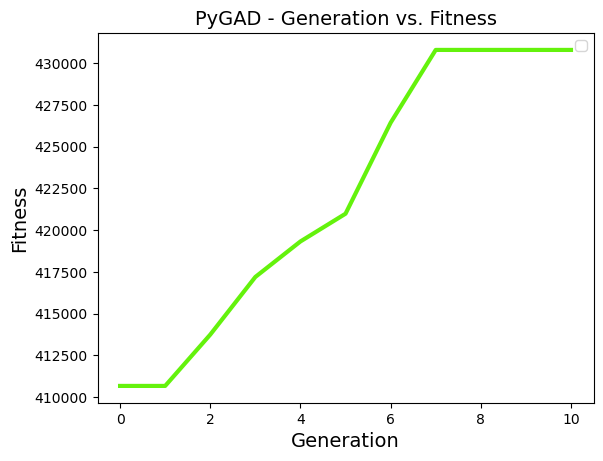

/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/brys/anaconda3/envs/pc-env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolu

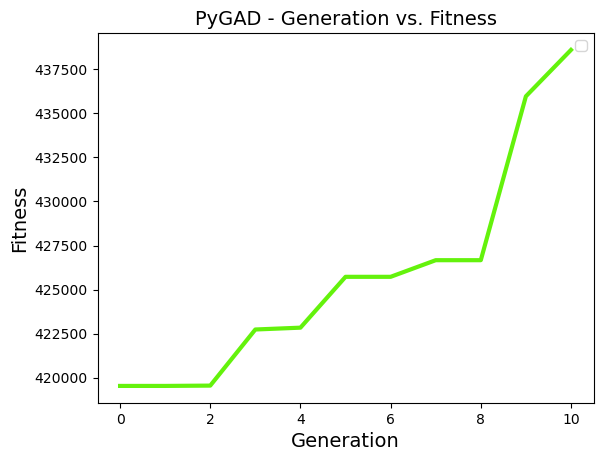

/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/brys/anaconda3/envs/pc-env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolu

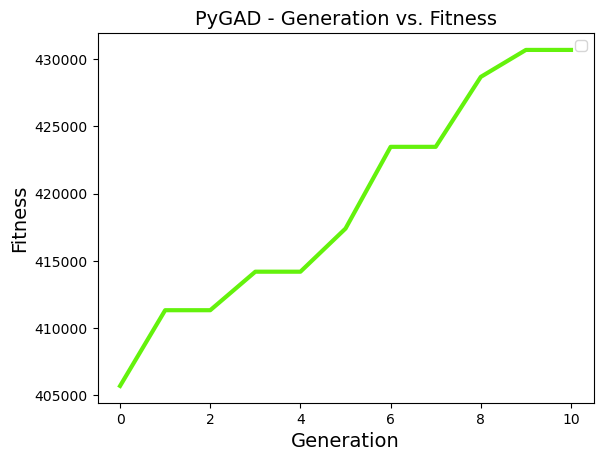

/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/brys/anaconda3/envs/pc-env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolu

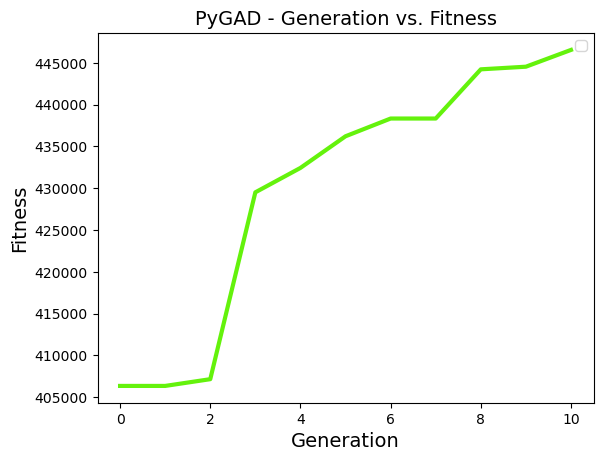

/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/tmp/ipykernel_3799/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']
/home/brys/anaconda3/envs/pc-env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolu

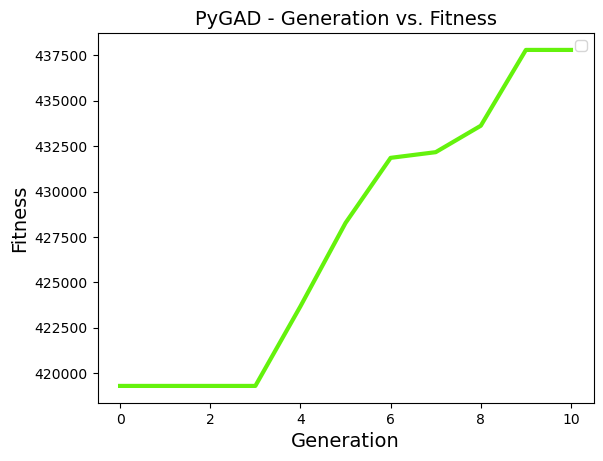

In [50]:
solutions = get_solutions(5)

In [52]:
solutions/1000

,random solution,solve total amount v1,solve total amount v2,solve variance only,solve assignment only,solve custom greedy,solve genetic
0,-405.045761,-137.94496,-4.995976,-4.995976,460.275241,-4.995976,-430.797782
1,-426.705748,-137.94496,-4.995976,-4.995976,460.275241,-4.995976,-435.969744
2,-384.088816,-137.94496,-4.995976,-4.995976,460.275241,-4.995976,-430.697760
3,-383.675792,-137.94496,-4.995976,-4.995976,460.275241,-4.995976,-444.532793
4,-369.321800,-137.94496,-4.995976,-4.995976,460.275241,-4.995976,-437.799769


# EPIC SOLVER 3000

In [109]:
def epic_solver_3000(nominators, num_of_vals, quantile_threshold = 0.99, stopping_criterion = 0.95):
    # step 1
    binary_matrix = create_binary_matrix(nominators)
    binary_matrix.sort_values(by='amount', inplace=True, ascending=False)
    
    # print("Step 1: binary_matrix")
    # display(binary_matrix)

    # step 2
    num_of_nominated_validators = binary_matrix.iloc[:, :-1].sum(axis=1)
    binary_matrix_divided = binary_matrix.iloc[:, :-1].div(num_of_nominated_validators, axis=0)
    amount_fraction_matrix = binary_matrix_divided.mul(binary_matrix['amount'], axis=0)

    # print("Step 2: amount_fraction_matrix")
    # display(amount_fraction_matrix)

    # step 3
    column_sums = amount_fraction_matrix.sum(axis=0)
    choosen_validators = column_sums.nlargest(num_of_vals).index

    # print("Step 3: choosen_validators")
    # display(choosen_validators)

    #step 4 
    sol = binary_matrix[choosen_validators]
    
    sol_filtered = sol[(sol != 0).any(axis=1)]

    sol_filtered_copy = sol_filtered.copy()

    sol_filtered_copy['amount'] = binary_matrix.loc[sol_filtered.index, 'amount']

    # print("Step 4: sol_filtered_copy")
    # display(sol_filtered_copy)

    percentile_95 = sol_filtered_copy['amount'].quantile(quantile_threshold)
    poors = sol_filtered_copy[sol_filtered_copy['amount'] <= percentile_95]
    rich = sol_filtered_copy[sol_filtered_copy['amount'] > percentile_95]

    poors_row_sums = poors.iloc[:, :-1].sum(axis=1)

    poors_sorted = poors.assign(poors_row_sums=poors_row_sums).sort_values(
        by=['poors_row_sums', 'amount'], 
        ascending=[True, False]
    ).drop(columns='poors_row_sums') 

    rich_row_sums = rich.iloc[:, :-1].sum(axis=1)

    rich_sorted = rich.assign(rich_row_sums=rich_row_sums).sort_values(
        by=['rich_row_sums', 'amount'], 
        ascending=[True, False]
    ).drop(columns='rich_row_sums') 

    # print("Step 4: poors_sorted")
    # display(poors_sorted)

    # print("Step 4: rich_sorted")
    # display(rich_sorted)

    solution = pd.DataFrame(0.0, index=sol.index, columns=sol.columns)
    validators_amount = pd.DataFrame([0.0] * len(sol.columns), index=sol.columns, columns=['amount']).T

    # print("Step 4: solution")
    # display(solution)

    # print("Step 4: validators_amount")
    # display(validators_amount)

    for index, row in poors_sorted.iterrows():
        # print("~~~ LOOP ~~~ Step 4 POORS: index, amount, validators_selected, min_validator, validators_amount, solution")
        # print(index)

        selection = row.iloc[:-1]
        amount = row.iloc[-1]
        validators_selected = list(selection[selection == 1].index)

        # print(amount)
        # print(validators_selected)

        min_validator = validators_amount.loc['amount', validators_selected].idxmin()
    
        validators_amount.loc['amount', min_validator] += amount
        solution.loc[index, min_validator] = amount

        # print(min_validator)
        # display(validators_amount)
        # display(solution)


    for index, row in rich_sorted.iterrows():
        # print("~~~ LOOP ~~~ Step 4 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")
        # print(index)

        selection = row.iloc[:-1]
        amount = row.iloc[-1]
        validators_selected = list(selection[selection == 1].index)

        # print(amount)
        # print(validators_selected)

        validators_sum = validators_amount.loc['amount', validators_selected].sum()
        total_sum = validators_sum + amount
        sum_divided = total_sum / len(validators_selected)

        # print(validators_sum)
        # print(total_sum)
        # print(sum_divided)

        remaining_amount = amount
    
        for validator in validators_selected:
            current_amount = validators_amount.loc['amount', validator]
            amount_to_add = sum_divided - current_amount
            amount_to_add = min(amount_to_add, remaining_amount)
            amount_to_add = max(amount_to_add, 0)
            
            validators_amount.loc['amount', validator] += amount_to_add

            solution.loc[index, validator] = amount_to_add
            
            remaining_amount -= amount_to_add
            
            if remaining_amount <= 0:
                break

        # display(validators_amount)
        # display(solution)
    

    # step 5, 6

    # print("Step 5,6 ##########################")

    prev_std = 1000000.0
    current_std = validators_amount.std(axis=1, ddof=0)['amount']

    while current_std < stopping_criterion * prev_std:
        print('Iteration')
        print(current_std)
        for index, row in poors_sorted.iterrows():
            # print("~~~ LOOP ~~~ Step 5,6 POORS: index, amount, validators_selected, min_validator, validators_amount, solution")
            # print(index)
            selection = row.iloc[:-1]
            amount = row.iloc[-1]
            validators_selected = list(selection[selection == 1].index)
            
            # print(amount)
            # print(validators_selected)

            solution_row = solution.loc[index]
            prev_selected_validator = solution_row[solution_row != 0].index[0]

            validators_amount[prev_selected_validator] -= amount

            min_validator = validators_amount.loc['amount', validators_selected].idxmin()

            validators_amount.loc['amount', min_validator] += amount
            solution.loc[index, prev_selected_validator] = 0
            solution.loc[index, min_validator] = amount

            # print(min_validator)
            # display(validators_amount)
            # display(solution)


        for index, row in rich_sorted.iterrows():
            # print("~~~ LOOP ~~~ Step 5,6 RICH: index, amount, validators_selected, validators_sum, total_sum, sum_divided, validators_amount, solution")
            # print(index)
            selection = row.iloc[:-1]
            amount = row.iloc[-1]
            validators_selected = list(selection[selection == 1].index)

            # print(amount)
            # print(validators_selected)

            total_sum = validators_amount.loc['amount', validators_selected].sum()
            sum_divided = total_sum / len(validators_selected)

            validators_amount.loc['amount'] -= solution.loc[index]

            # print(validators_sum)
            # print(total_sum)
            # print(sum_divided)

            remaining_amount = amount
        
            for validator in validators_selected:
                current_amount = validators_amount.loc['amount', validator]
                amount_to_add = sum_divided - current_amount
                amount_to_add = min(amount_to_add, remaining_amount)
                amount_to_add = max(amount_to_add, 0)
                
                validators_amount.loc['amount', validator] += amount_to_add

                solution.loc[index, validator] = amount_to_add
                
                remaining_amount -= amount_to_add
                
                if remaining_amount <= 0:
                    break

            # display(validators_amount)
            # display(solution)

        prev_std = current_std
        current_std = validators_amount.std(axis=1, ddof=0)['amount']

    print('final std:')
    print(validators_amount.std(axis=1, ddof=0)['amount'])

    return solution


#

In [82]:
test_data_validators = ['val_A', 'val_B', 'val_C', 'val_D', 'val_E', 'val_F', 'val_G', 'val_H', 'val_I', 'val_J', 'val_K']
test_data_nominators_cols = ['stash_address', 'bonded_amount', 'targets']
test_data_nominators_names = ['nom_A', 'nom_B', 'nom_C', 'nom_D', 'nom_E', 'nom_F', 'nom_G', 'nom_H', 'nom_I', 'nom_J', 'nom_K', 'nom_L', 'nom_M', 'nom_N', 'nom_O', 'nom_P', 'nom_Q', 'nom_R', 'nom_S', 'nom_T']

test_data_df = pd.DataFrame({
    'stash_address': test_data_nominators_names,
    'bonded_amount': [random.uniform(1, 50) for _ in range(len(test_data_nominators_names))],
    'targets': [','.join(random.sample(test_data_validators, random.randint(1, 3))) for _ in range(len(test_data_nominators_names))]
})

test_data_df

test_data_2_validators = ['val_A', 'val_B', 'val_C', 'val_D', 'val_E']
test_data_2 = pd.DataFrame({
    'stash_address': ['A', 'B', 'C', 'D', 'E', 'F'],
    'bonded_amount': [10.0, 3.0, 8.0, 2.0, 1.0, 5.0],
    'targets': ['val_A', 'val_B,val_D', 'val_A,val_C,val_E', 'val_C,val_D', 'val_B', 'val_A,val_B,val_E']
})

test_data_2
test_data_2_binary = create_binary_matrix(test_data_2)
test_data_2_binary

,val_A,val_B,val_C,val_D,val_E,amount
stash_address,,,,,,
A,1,0,0,0,0,10.0
B,0,1,0,1,0,3.0
C,1,0,1,0,1,8.0
D,0,0,1,1,0,2.0
E,0,1,0,0,0,1.0
F,1,1,0,0,1,5.0


In [107]:
epic_result = epic_solver_3000(test_data_2, 3, 0.6)



Iteration
4.546060565661952
Iteration
0.816496580927726
final std:
0.816496580927726


In [110]:
epic_result_real = epic_solver_3000(nominators, 297, stopping_criterion=0.99)

Iteration
0.012990028976624875
Iteration
0.010602517964135413
Iteration
0.010469839365668684
final std:
0.010433094000346766


In [111]:
epic_result_real = epic_solver_3000(nominators, 297, quantile_threshold=0.95, stopping_criterion=0.99)

Iteration
0.013365474777076463
Iteration
0.01144831775612353
final std:
0.011929418860771753
